<a href="https://colab.research.google.com/github/Raphlawren/TimeSeries_-forecast-of-change-in-shape-coordinates/blob/main/ShapeSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/yearssum.csv')

In [ ]:
df.head()

,id,x,y,year
0,1,-0.12802,0.43291,2000-01-01
1,2,-0.12802,0.43350,2000-01-01
2,3,-0.12804,0.43409,2000-01-01
3,4,-0.12807,0.43468,2000-01-01
4,5,-0.12810,0.43527,2000-01-01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      3240 non-null   int64         
 1   x       3240 non-null   float64       
 2   y       3240 non-null   float64       
 3   year    3240 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 101.4 KB


In [ ]:
df['year'] = pd.to_datetime(df['year'])

In [ ]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [ ]:
from prophet import Prophet
import pandas as pd

predictions = []
unique_points = df["id"].unique()

for point in unique_points:
    point_data = df[df["id"] == point].copy()

    # 1) Ensure 'ds' is datetime
    point_data['ds'] = pd.to_datetime(point_data['year'], format='%Y')

    last_year = point_data['ds'].dt.year.max()
    periods   = 3  # or 3 if you want 3 years ahead

    # 2) Fit X model
    m_x = Prophet(yearly_seasonality=False)
    m_x.fit(point_data[['ds','x']].rename(columns={'x':'y'}))

    future_x = m_x.make_future_dataframe(periods=periods, freq='YE')
    fx       = m_x.predict(future_x)
    x_preds  = fx['yhat'].iloc[-periods:].values  # grab last `periods` predictions

    # 3) Fit Y model
    m_y = Prophet(yearly_seasonality=False)
    m_y.fit(point_data[['ds','y']].rename(columns={'y':'y'}))

    future_y = m_y.make_future_dataframe(periods=periods, freq='YE')
    fy       = m_y.predict(future_y)
    y_preds  = fy['yhat'].iloc[-periods:].values

    # 4) Append historical points
    for _, r in point_data.iterrows():
        predictions.append({
            'id':   point,
            'year': r['ds'].year,
            'x':    r['x'],
            'y':    r['y']
        })

    # 5) Append forecasted points
    for i in range(periods):
        predictions.append({
            'id':   point,
            'year': last_year + i + 1,
            'x':    x_preds[i],
            'y':    y_preds[i]
        })

predicted_df = pd.DataFrame(predictions)
predicted_df.to_csv("PredictedCoords.csv", index=False)
print(predicted_df.tail())


In [ ]:
predicted_df.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011])

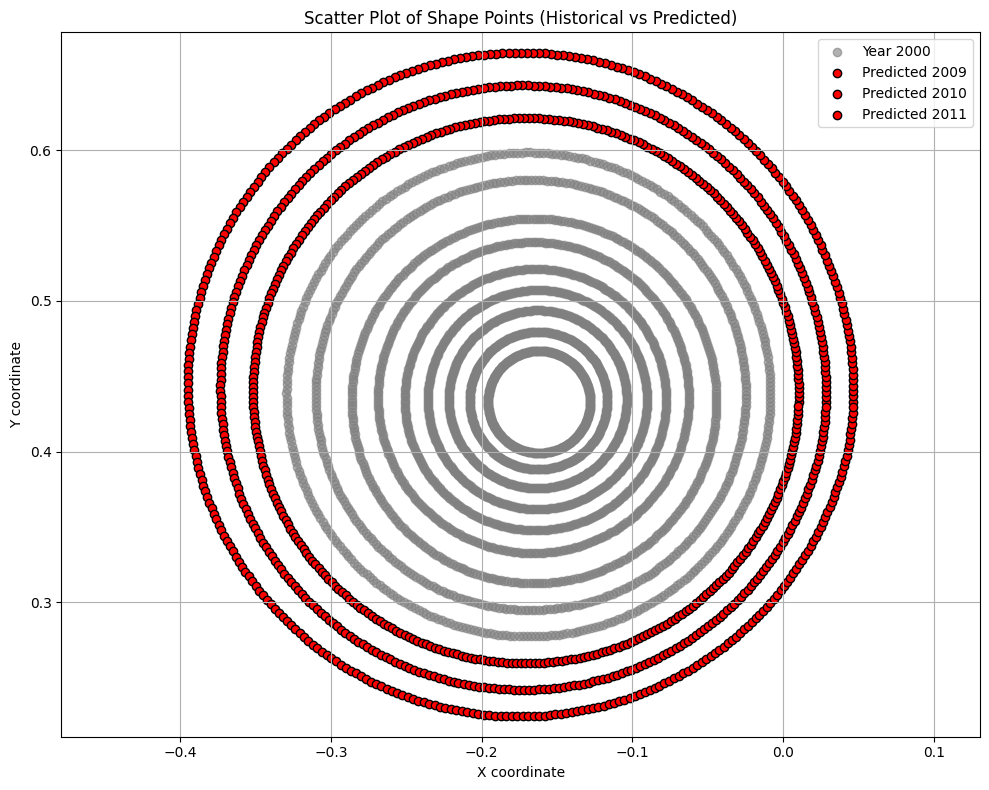

In [ ]:
# Reload essentials after the crash
import pandas as pd
import matplotlib.pyplot as plt

# Load predicted coordinates
predicted_df = pd.read_csv("PredictedCoords.csv")

# Ensure year is treated as string for consistent plotting
predicted_df['year'] = predicted_df['year'].astype(str)

# Identify predicted years by finding the latest ones
years_sorted = sorted(predicted_df['year'].unique())
predicted_years = years_sorted[-3:]  # assuming the last 3 years are predicted
historical_years = [yr for yr in years_sorted if yr not in predicted_years]

plt.figure(figsize=(10, 8))

# Plot historical data in gray
for yr in historical_years:
    df_year = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_year['x'], df_year['y'], color='gray', alpha=0.6, label=f"Year {yr}" if yr == historical_years[0] else "")

# Plot predicted data in red
for yr in predicted_years:
    df_pred = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_pred['x'], df_pred['y'], color='red', edgecolor='black', label=f"Predicted {yr}")

plt.title("Scatter Plot of Shape Points (Historical vs Predicted)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()
